<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Baum_Welch_(EM)__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baum-Welch (EM) Algorithm for HMM

The **EM_HMM_Categorical** class applies the Baum-Welch (EM) algorithm for parameter learning of HMMs with a discrete likelihood for the emission model. Implemented from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html).

Given the observations $y_{1},\cdots, y_{T}$, we aim to find:
\begin{align*}
A &= \Pr(\mathbf z_{t}|\mathbf z_{t-1}) \\
B &= \Pr(\mathbf y|\mathbf z) \\
\pi &= \Pr(\mathbf z_1)
\end{align*}


---


At iteration $t-1$, we have:

1.   Parameters $\mathbf \theta_{t-1} = (A_{t-1}, B_{t-1}, \pi_{t-1})$
2.   Smoothed latent posteriors $\gamma = \Pr(\mathbf z|\mathbf y, \theta_{t-1})\in \mathbb{R}^{B\times N\times K\times 1}$
3.   Two slice marginals $\xi =\Pr(\mathbf z_{t-1}, \mathbf z_{t}|\mathbf y, \theta_{t-1})\in \mathbb{R}^{B\times N\times K\times K}$
4. Observations $\mathbf y\in \mathbb{R}^{B\times N\times 1}$

where $B, N, K$ denote the batch dimension, time steps, and number of latent states respectively. The Baum-Welch (EM) algorithm is then iterated as follows:


> **E Step**
\begin{align*}
\mathop{\mathbb{E}}[N_K^1] &= \sum_B \gamma\ [:, 0, ...]\\
\mathop{\mathbb{E}}[N_K] &= \sum_B\sum_N \gamma\ [:, 1, ...]\\
\mathop{\mathbb{E}}[N_{JK}] &= \sum_B\sum_N \xi\\
\text{for } v\in \text{dim}(B)\\
\mathop{\mathbb{E}}[M_{Kv}] &= \sum_B\sum_N \gamma \cdot \mathbb{I}\ [y_n=v]
\end{align*}
Note that the summation is done with respect to matrices/vectors of each respective batch.

>**M step** 
>
>Update $\mathbf \theta_{t} = (A_{t}, B_{t}, \pi_{t})$ where:
\begin{align*}
A_t &= \text{normalize}(\mathop{\mathbb{E}}[N_{JK}])\\
B_t &= \text{normalize}(\mathop{\mathbb{E}}[M_{KV}])\\
\pi_t &= \text{normalize}(\mathop{\mathbb{E}}[N_K^1])\\
\end{align*}
where $\text{normalize}()$ corresponds to division by their respective number of occurences, times, etc. that will make $\theta_{t}$ valid stochastic vectors/matrices.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

## Baum-Welch (EM)

In [20]:
class EM_HMM_Categorical:
  def __init__(self, HMM_Inference, A_shape, B_shape, π_shape, A=None, B=None, π=None):
    self.batch_dims = observations.shape[0]
    init_distrib = tfp.distributions.Beta(2, 2)
    self.A_t = A if tf.is_tensor(A) else self.normalize(init_distrib.sample([*A_shape]), -1)
    self.B_t = B if tf.is_tensor(B) else self.normalize(init_distrib.sample([*B_shape]), -1) 
    self.π_t = π if tf.is_tensor(π) else self.normalize(init_distrib.sample([*π_shape]), -2) 
    self.HMM_Inference = HMM_Inference
    self.B_dims = B_shape[1]
    self.iter = iter
    self.parameters = {
        "A": self.A_t,
        "B": self.B_t,
        "π": self.π_t,
        "Q": tf.constant([0.0])
    }
    
  def iter_print(self, curr_iter, LL_t):
    #tf.print('\nIteration {}:\n A:\n{}\n\n B:\n{}\n\n π:\n{}'.format(curr_iter, *self.parameters.values()))
    tf.print('Iteration {}:\tECDLL = {}'.format(curr_iter, LL_t))

  def normalize(self, x, dim):
    return x / tf.reduce_sum(x, dim, keepdims=True)

  def expeted_CDLL(self, A_t, B_t, γ_t, π_t, local_evidence, E_N1, E_NJK):
    Q_1 = tf.reduce_sum(E_N1 * tf.math.log(π_t))
    Q_2 = tf.reduce_sum(E_NJK * tf.math.log(A_t))
    Q_3 = tf.reduce_sum(γ_t * tf.math.log(local_evidence))
    return Q_1 + Q_2 + Q_3

  def E_step(self, observations, A_t, B_t, π_t):
    HMM_t = self.HMM_Inference(A_t, B_t, π_t, observations)
    a_t, a_Z = HMM_t.Forward()
    γ_t, β_t = HMM_t.Backward(a_t, a_Z)
    ξ_t = HMM_t.TwoSlice_Marginals(a_t, β_t)
    
    for v in range(self.B_dims):
      indices = tf.where(observations == v)
      E_Mkv = tf.reduce_sum(tf.gather_nd(γ_t, indices), 0)[tf.newaxis, ...]
      if v == 0:
        E_MKV = E_Mkv
      else:
        E_MKV = tf.concat([E_MKV, E_Mkv], 0)

    E_N1 = tf.reduce_sum(γ_t[:, 0], 0)
    E_NK = tf.reduce_sum(tf.reduce_sum(γ_t[:, 1:], 1), 0)
    E_NJK = tf.reduce_sum(tf.reduce_sum(ξ_t, 1), 0)
    Q_t = self.expeted_CDLL(A_t, B_t, γ_t, π_t, HMM_t.local_evidence, E_N1, E_NJK)
    return E_N1, E_NK, E_NJK, E_MKV, Q_t
  
  def M_step(self, E_N1, E_NK, E_NJK, E_MKV):
    A_t = (E_NJK + 1) / (tf.reduce_sum(E_NJK, -1, keepdims=True) + 2)
    B_t = tf.transpose(tf.squeeze((E_MKV + 1) / (E_NK + 2)))
    π_t = (E_N1 + 1) / (self.batch_dims + 2)
    return A_t, B_t, π_t

  def __call__(self, observations, iter=1):
    [A_t, B_t, π_t, Q] = self.parameters.values()
    for i in range(iter):
      E_N1, E_NK, E_NJK, E_MKV, Q_t = self.E_step(observations, A_t, B_t, π_t)
      A_t, B_t, π_t = self.M_step(E_N1, E_NK, E_NJK, E_MKV)
      Q = tf.concat([Q, Q_t[..., tf.newaxis]], 0)
      self.parameters.update({
        "A": A_t,
        "B": B_t,
        "π": π_t,
      })
      self.iter_print(i + 1, Q_t)
    self.parameters.update({"Q": Q})

## Forward-Backwards
(See [HMM Inference](https://colab.research.google.com/drive/12JfQRmJOgHXOE1j-gXjfSDHlODpp3RVE?usp=sharing))

In [5]:
class HMM_Categorical_Inference:
  def __init__(self, transition_matrix, observation_matrix, states_0, observations):
    local_evidence = tf.gather(observation_matrix, observations, axis=1)
    self.local_evidence = tf.transpose(local_evidence, [1, 2, 0])[..., tf.newaxis]
    self.batch_dims = self.local_evidence.shape[0]
    self.num_steps = self.local_evidence.shape[1]
    self.transition_matrix = transition_matrix
    self.states_0 = states_0
    self.num_states = transition_matrix.shape[0]

  def normalizing_constant(self, x):
    return (tf.reduce_sum(x, -2, keepdims=True))

  def Forward(self):
    a_t = self.states_0 * self.local_evidence[:, 0]
    Z = self.normalizing_constant(a_t)
    a = a_t / Z
    for i in range(1, self.num_steps):
      a_t = self.local_evidence[:, i] * (tf.transpose(self.transition_matrix) @ a_t)
      Z_t = self.normalizing_constant(a_t)
      a_t = a_t / Z_t
      Z = tf.concat([Z, Z_t], 1)
      a = tf.concat([a, a_t], 2)
    return tf.transpose(a, [0, 2, 1])[..., tf.newaxis], Z

  def Backward(self, a, a_Z):
    β = β_t = tf.fill([self.batch_dims, self.num_states, 1], 1.)
    for i in range(self.num_steps - 1, 0, -1):
      β_t = self.transition_matrix @ (self.local_evidence[:, i] * β_t)
      β_t = β_t / a_Z[:, i][..., tf.newaxis]
      β = tf.concat([β, β_t], 2)    
    β = tf.reverse(β, [-1])
    β = tf.transpose(β, [0, 2, 1])[..., tf.newaxis]
    g = a * β
    g = g / self.normalizing_constant(g)
    return g, β

  def TwoSlice_Marginals(self, a, β):
    a = a[:, :-1]
    β = β[:, 1:]
    λ = self.local_evidence[:, 1:]
    ξ = self.transition_matrix * (a @ tf.transpose(λ * β, [0, 1, 3, 2]) )
    K = tf.reduce_sum(tf.reduce_sum(ξ, -1), -1, keepdims=True)
    ξ = ξ / tf.broadcast_to(K[..., tf.newaxis], ξ.shape)
    return ξ

## Casino HMM Parameter Learning

### Set the ground-truth parameters $(A_g, B_g, \pi_g)$

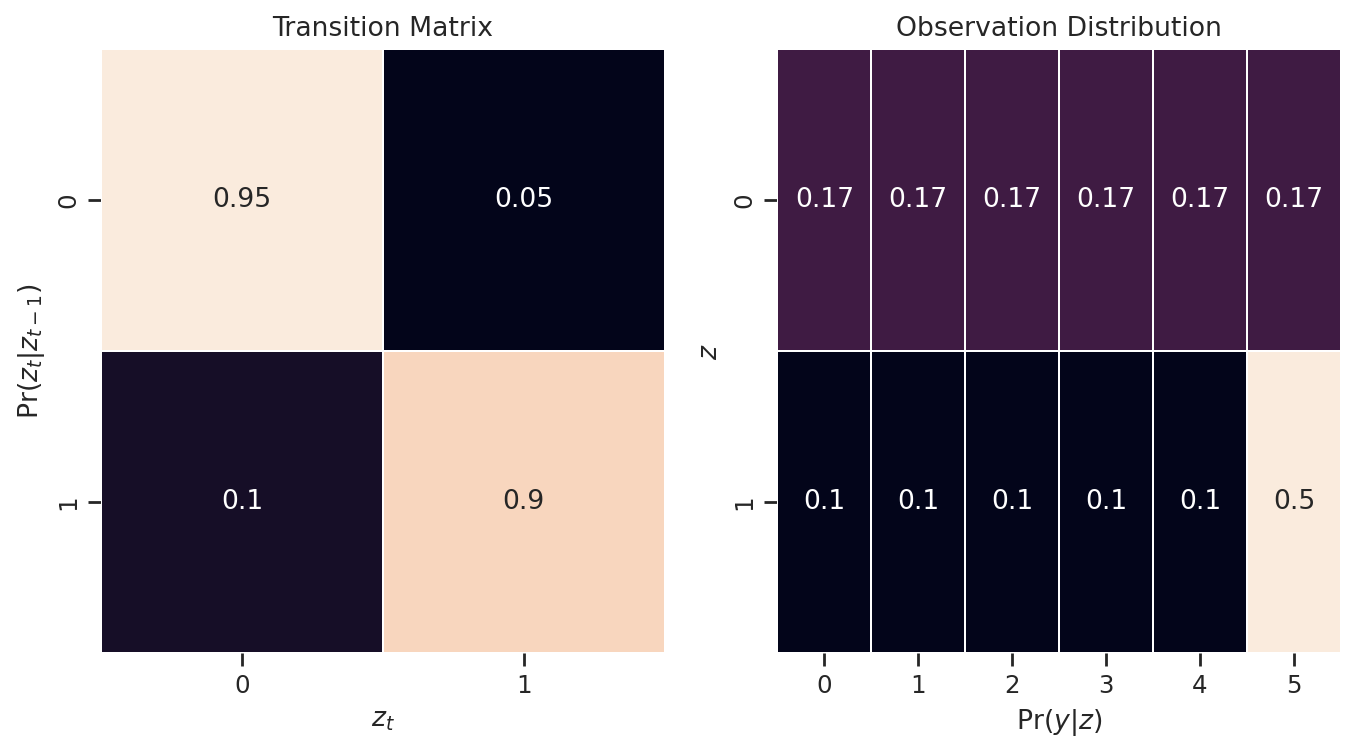

In [21]:
num_states = 2

π_g = tf.constant([
    [0.5],
    [0.5]
])

A_g = tf.constant([
    [0.95, 0.05], 
    [0.1, 0.9]
])

B_g = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(A_g, annot=True, linewidth=.5, ax=axes[0], cbar=False)
sns.heatmap(B_g, annot=True, linewidth=.5, ax=axes[1], cbar=False)
axes[0].set(xlabel='$z_{t}$', ylabel='$\Pr(z_{t}|z_{t-1})$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution'); plt.show()

### Generate $N$ bacthes of Casino HMM observations

In [22]:
def CasinoHMM(A, B, π, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(π)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=A).sample([batch_dims, steps])
  observation_distribution = tfd.Categorical(probs=B).sample([batch_dims, steps])
  for i in range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    if i == 0: 
      state = state_t
      obs = obs_t
    else: 
      state = tf.concat([state, state_t], 1)
      obs = tf.concat([obs, obs_t], 1)
  return state, obs

In [23]:
num_batches = 5
num_steps = 5000
true_states, observations = CasinoHMM(A_g, B_g, π_g, num_steps, num_batches)
print('Generated {} batches of {}-step Casino HMM samples'.format(num_batches, num_steps), '\n')

Generated 5 batches of 5000-step Casino HMM samples 



### Parameter learning

In [ ]:
A_0 = tf.constant([
    [0.5, 0.5],
    [0.5, 0.5]
])

B_0 = tf.constant([
    [0.2, 0.1, 0.2, 0.1, 0.2, 0.2],
    [0.1, 0.2, 0.1, 0.2, 0.1, 0.3]
])

π_0 = tf.constant([
    [0.5],
    [0.5]
])

HMM_fit = EM_HMM_Categorical(HMM_Categorical_Inference, A_shape=[2,2], B_shape=[2,6], π_shape=[2, 1], A=A_0, B=B_0, π=π_0)
HMM_fit(observations, iter=250)

True parameters

[[0.95 0.05]
 [0.1  0.9 ]]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]

[[0.5]
 [0.5]] 


Learned parameters 

[[0.95103186 0.04896817]
 [0.0977193  0.90228075]]

[[0.1690216  0.16337177 0.16831355 0.16508617 0.17017075 0.164535  ]
 [0.09903714 0.10181331 0.10177226 0.09226784 0.09374099 0.5119307 ]]

[[0.7590197 ]
 [0.24098036]] 




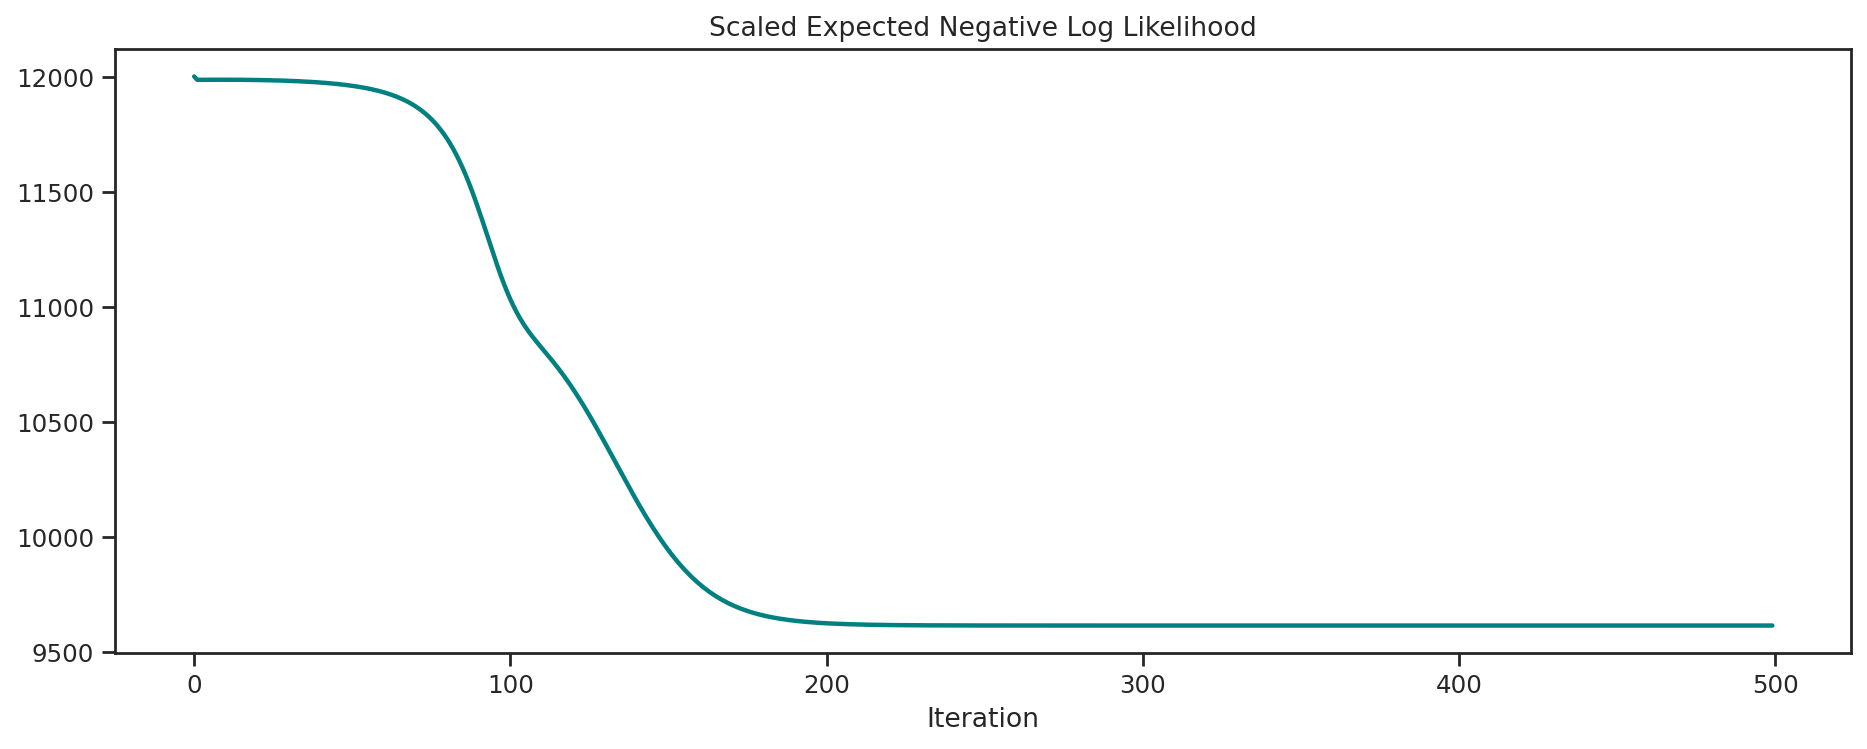

In [28]:
tf.print('True parameters\n\n{}\n\n{}\n\n{}'.format(A_g, B_g, π_g), '\n\n')
tf.print('Learned parameters \n\n{}\n\n{}\n\n{}'.format(HMM_fit.parameters.get('A'), HMM_fit.parameters.get('B'), HMM_fit.parameters.get('π')), '\n\n')
Q_ = - HMM_fit.parameters.get('Q') / num_batches
plt.figure(figsize=(14, 5))
plt.plot(Q_[1:], color="teal", linewidth=2)
plt.title("Scaled Expected Negative Log Likelihood"); plt.xlabel('Iteration'); plt.show()